## Import tools

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Parameters

In [2]:
batch_size = 32
img_height = 224
img_width = 224


In [7]:
TRAIN_DIR = r'C:\Users\madar\Documents\Github_Codes\archive\train'
TEST_DIR = r'C:\Users\madar\Documents\Github_Codes\archive\test'
VALID_DIR = r'C:\Users\madar\Documents\Github_Codes\archive\validation'

## Generate data batch

### Train data

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,
                                                               seed=2509,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 3581 files belonging to 36 classes.


### Valid data

In [8]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(VALID_DIR,
                                                               seed=2509,
                                                               image_size=(img_height, img_width),
                                                               shuffle=False,
                                                               batch_size=batch_size)

Found 351 files belonging to 36 classes.


### Test Data

In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                                              seed=2509,
                                                              image_size=(img_height, img_width),
                                                              shuffle=False,
                                                              batch_size=batch_size)

Found 359 files belonging to 36 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


## View Data

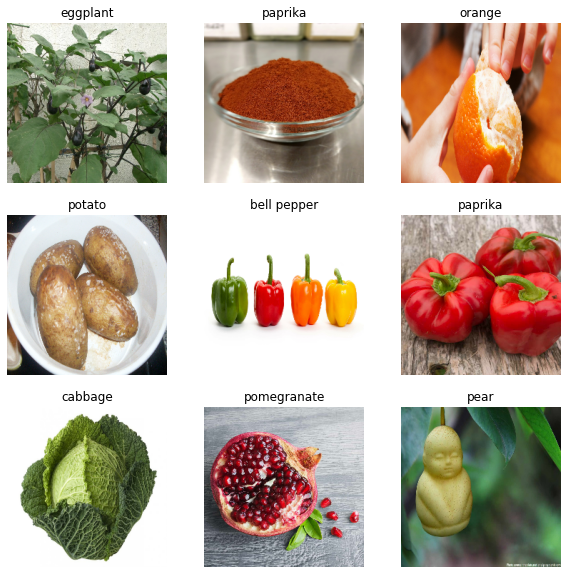

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


## Base model

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 4s 0us/step


In [13]:
base_model.trainable = False

## Data augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

## Define additional layers

In [15]:
inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)

In [16]:
model = tf.keras.Model(inputs=inputs, outputs=x, name="flower_vegetable_Detection_MobileNetV2")

## Compile the model

In [17]:
# Compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    metrics = ["accuracy"])

In [15]:
model.summary()

Model: "flower_vegetable_Detection_MobileNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)               

## Fit the model

In [18]:
initial_epochs = 5

In [19]:
# Fit the model
history = model.fit(x=train_ds,
                    epochs= initial_epochs,
                    validation_data=valid_ds)

Epoch 1/5
112/112 [==============================] - 508s 4s/step - loss: 2.1954 - accuracy: 0.4371 - val_loss: 0.4603 - val_accuracy: 0.8433
Epoch 2/5
112/112 [==============================] - 575s 5s/step - loss: 0.9406 - accuracy: 0.7017 - val_loss: 0.3145 - val_accuracy: 0.8832
Epoch 3/5
112/112 [==============================] - 532s 5s/step - loss: 0.7113 - accuracy: 0.7689 - val_loss: 0.2978 - val_accuracy: 0.8974
Epoch 4/5
112/112 [==============================] - 485s 4s/step - loss: 0.5890 - accuracy: 0.7993 - val_loss: 0.2649 - val_accuracy: 0.8946
Epoch 5/5
112/112 [==============================] - 503s 4s/step - loss: 0.5108 - accuracy: 0.8276 - val_loss: 0.1998 - val_accuracy: 0.9231


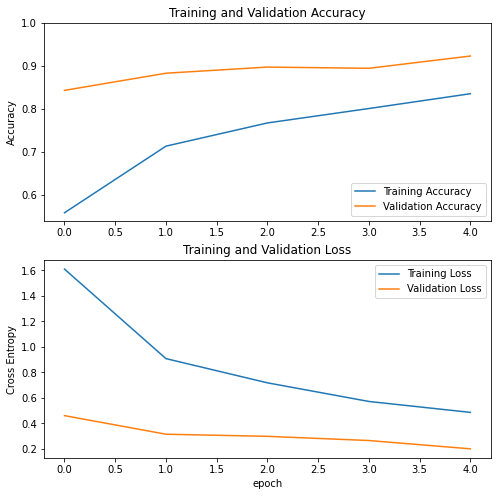

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tune

In [21]:
base_model.trainable = True

In [28]:
# Compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(1e-5),
    metrics = ["accuracy"])

In [29]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds)

Epoch 5/10
112/112 [==============================] - 1198s 10s/step - loss: 0.3606 - accuracy: 0.8741 - val_loss: 0.1529 - val_accuracy: 0.9402
Epoch 6/10
112/112 [==============================] - 1267s 11s/step - loss: 0.2662 - accuracy: 0.9057 - val_loss: 0.1404 - val_accuracy: 0.9459
Epoch 7/10
112/112 [==============================] - 1189s 11s/step - loss: 0.2205 - accuracy: 0.9237 - val_loss: 0.1477 - val_accuracy: 0.9516
Epoch 8/10
112/112 [==============================] - 1006s 9s/step - loss: 0.2279 - accuracy: 0.9183 - val_loss: 0.1482 - val_accuracy: 0.9430
Epoch 9/10
112/112 [==============================] - 812s 7s/step - loss: 0.1849 - accuracy: 0.9382 - val_loss: 0.1319 - val_accuracy: 0.9487
Epoch 10/10
112/112 [==============================] - 869s 8s/step - loss: 0.1813 - accuracy: 0.9381 - val_loss: 0.1153 - val_accuracy: 0.9573


In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

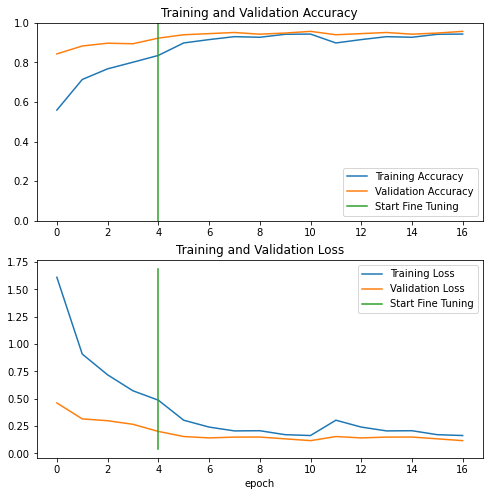

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Predictions

In [33]:
# Make prediction on the validation data (not used to train on)
predictions = model.predict(valid_ds, verbose=1)

11/11 [==============================] - 34s 3s/step


In [35]:
predictions.shape

(351, 36)

In [36]:
np.sum(predictions[0])

1.0000001

In [37]:
predictions[0]

array([8.9478189e-01, 4.7484027e-11, 1.4076235e-06, 1.3502685e-10,
       1.2695581e-11, 2.9500185e-09, 9.8826940e-11, 5.4442888e-11,
       3.8844403e-09, 3.0727994e-12, 6.3447886e-11, 3.3589615e-08,
       4.4463452e-12, 1.5752137e-09, 2.5654023e-09, 1.8852937e-10,
       1.9966648e-09, 6.7914221e-09, 1.1443766e-10, 1.2976629e-06,
       1.9970658e-08, 2.4645262e-06, 3.4304151e-08, 6.6965848e-05,
       5.9826151e-13, 5.1799374e-11, 1.0513342e-01, 3.7251791e-08,
       1.4783878e-06, 3.2260649e-11, 7.4876425e-12, 7.6839662e-10,
       6.0109020e-09, 1.0650587e-05, 1.3724356e-07, 2.8918180e-07],
      dtype=float32)

In [41]:
class_names[np.argmax(predictions[0])]

'apple'

In [42]:
class_names[np.argmax(predictions[15])]

'banana'

In [43]:
score = tf.nn.softmax(predictions[0])
score

<tf.Tensor: shape=(36,), dtype=float32, numpy=
array([0.06514772, 0.02662566, 0.0266257 , 0.02662566, 0.02662566,
       0.02662566, 0.02662566, 0.02662566, 0.02662566, 0.02662566,
       0.02662566, 0.02662566, 0.02662566, 0.02662566, 0.02662566,
       0.02662566, 0.02662566, 0.02662566, 0.02662566, 0.0266257 ,
       0.02662566, 0.02662572, 0.02662566, 0.02662745, 0.02662566,
       0.02662566, 0.02957735, 0.02662566, 0.0266257 , 0.02662566,
       0.02662566, 0.02662566, 0.02662566, 0.02662594, 0.02662566,
       0.02662567], dtype=float32)>

## Save model and class name

In [44]:
np.save('class_names.npy',class_names)

In [45]:
model.save("flower_vegetable_detection_mobilenetv2.h5")

## Test Data

In [46]:
model.evaluate(test_ds)

12/12 [==============================] - 42s 3s/step - loss: 0.1133 - accuracy: 0.9582


[0.113297238945961, 0.9582172632217407]